In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import IPython
from glob import glob
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import tqdm
#import seaborn as sns
import albumentations as A
import torch
import torch.nn as nn
import timm
from torcheval.metrics import R2Score
import wandb
import torchvision
from sklearn.model_selection import StratifiedKFold

/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:

BASE_DIR = os.path.join(os.getcwd() , 'data')
train_df = pd.read_csv(BASE_DIR  +  '/train.csv')
TRAIN_VAL_SPLIT_SIZE = 0.2
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 256

LEARNING_RATE =  1e-4
EPOCHS = 18
TIM_NUM_CLASS = 1408
Normalize_transform_type = "log_transform"
RANDOM_NUMBER = 42
NUM_FLODS  = 5
NUM_CLASSES = 6
TRAITS_NAME = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]
FOLD = 0 # Which fold to set as validation data
TARGET_IMAGE_SIZE  = 128
T_MAX =        9
LR_MODE = "step" # LR scheduler mode from one of "cos", "step", "exp"
torch.manual_seed(RANDOM_NUMBER)

In [3]:
#wandb.login()

# wandb.init(project="cs680v2_normalized",
#     config={
#        "learning_rate": LEARNING_RATE,
#         "epochs": EPOCHS,
#         "batch_size" : TRAIN_BATCH_SIZE,
#     }
# )

In [5]:
EXTRA_COLOUMN = [
    'WORLDCLIM_BIO1_annual_mean_temperature',
'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
'WORLDCLIM_BIO15_precipitation_seasonality',
'WORLDCLIM_BIO4_temperature_seasonality',
'SOIL_ocd_100.200cm_mean_0.01_deg',
'WORLDCLIM_BIO12_annual_precipitation',
'WORLDCLIM_BIO7_temperature_annual_range',
'SOIL_cec_0.5cm_mean_0.01_deg',
'SOIL_nitrogen_0.5cm_mean_0.01_deg',
'SOIL_ocd_60.100cm_mean_0.01_deg',
'SOIL_ocd_30.60cm_mean_0.01_deg',
'SOIL_clay_100.200cm_mean_0.01_deg',
'SOIL_soc_100.200cm_mean_0.01_deg',
'SOIL_nitrogen_100.200cm_mean_0.01_deg',
'SOIL_cec_100.200cm_mean_0.01_deg',
'SOIL_clay_15.30cm_mean_0.01_deg',
'SOIL_soc_60.100cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
'SOIL_nitrogen_30.60cm_mean_0.01_deg',
'SOIL_clay_5.15cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
'SOIL_ocd_0.5cm_mean_0.01_deg',
'SOIL_ocd_5.15cm_mean_0.01_deg',
'SOIL_cfvo_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
'SOIL_cfvo_30.60cm_mean_0.01_deg',
'SOIL_cfvo_0.5cm_mean_0.01_deg',
'SOIL_soc_15.30cm_mean_0.01_deg',
'SOIL_nitrogen_15.30cm_mean_0.01_deg',
'SOIL_nitrogen_5.15cm_mean_0.01_deg',
'SOIL_clay_0.5cm_mean_0.01_deg',
'SOIL_nitrogen_60.100cm_mean_0.01_deg',
'SOIL_soc_0.5cm_mean_0.01_deg',
'SOIL_ocd_15.30cm_mean_0.01_deg',
'SOIL_ocs_0.30cm_mean_0.01_deg',
'SOIL_clay_30.60cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
'SOIL_cfvo_15.30cm_mean_0.01_deg',
'SOIL_silt_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8',
'SOIL_soc_30.60cm_mean_0.01_deg',
'SOIL_cfvo_5.15cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
'SOIL_silt_0.5cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
'SOIL_sand_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12'
]


In [6]:
from sklearn.preprocessing import StandardScaler
SCALAR = StandardScaler()

def create_val_train_dataset(BASE_DIR,train_split_size,scalar:StandardScaler):
    df = pd.read_csv(BASE_DIR  +  '/train.csv')
    df["image_path"] = BASE_DIR + "/train_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe

    # standardize the dataset
    scalar.fit(df[EXTRA_COLOUMN])
    df[EXTRA_COLOUMN] = scalar.transform(df[EXTRA_COLOUMN])
    
    # skf = StratifiedKFold(n_splits=NUM_FLODS, shuffle=True, random_state=42)

    # # Create separate bin for each traits
    # for i, trait in enumerate(TRAITS_NAME):

    #     # Determine the bin edges dynamically based on the distribution of traits
    #     bin_edges = np.percentile(df[trait], np.linspace(0, 100, NUM_FLODS + 1))
    #     df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

    # # Concatenate the bins into a final bin
    # df["final_bin"] = (
    #     df[[f"bin_{i}" for i in range(NUM_CLASSES)]]
    #     .astype(str)
    #     .agg("".join, axis=1)
    # )

    # # Perform the stratified split using final bin
    # df = df.reset_index(drop=True)
    # for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    #     df.loc[valid_idx, "fold"] = fold
    # sample_df = df.copy()
    # train_df = sample_df[sample_df.fold != FOLD]
    # val_df = sample_df[sample_df.fold == FOLD]
 
 
    
    # for column in TRAITS_NAME:
    #     lower_quantile = train_df[column].quantile(0.005)
    #     upper_quantile = train_df[column].quantile(0.985)  
    # train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]
    

 
    
    train_df , val_df = train_test_split(df,test_size=train_split_size,shuffle=True)
    
    print(f"# Num Train: {len(train_df)} | Num Valid: {len(val_df)}")
    
    train_df.reset_index(drop=True , inplace  = True)
    val_df.reset_index(drop = True , inplace = True)
    return  train_df , val_df
def create_test_dataset(BASE_DIR,scalar):
    df = pd.read_csv(BASE_DIR  +  '/test.csv')
    df["image_path"] = BASE_DIR + "/test_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
    df[EXTRA_COLOUMN] = scalar.transform(df[EXTRA_COLOUMN])
    return df

train_df , val_df = create_val_train_dataset(BASE_DIR,TRAIN_VAL_SPLIT_SIZE,scalar = SCALAR)
test_df = create_test_dataset(BASE_DIR,scalar=SCALAR)


# Num Train: 34690 | Num Valid: 8673


In [7]:
class NormalizeOutput():
    def __init__(self,type_transform ):
        self.transform = type_transform
        self.mean = 0
        self.std = 0
        self.mean_tensor = 0
        self.std_tensor = 0
        
        pass
    def normalize(self,df):
        if self.transform == "log_transform":
            mean = np.log10(df).mean()
            std = np.log10(df).std()
            self.mean = mean
            self.std = std
            self.mean_tensor = torch.Tensor(self.mean.values).to(DEVICE)
            self.std_tensor = torch.Tensor(self.std.values).to(DEVICE)
            return (np.log10(df) - self.mean)/self.std
    def denormalize(self,df):
        if self.mean is None or self.std is None :
            raise Exception("mean and/std is not defined ")
        if self.normalize == "log_transform":
            df_denormalize =10**((df*self.std) + self.mean )
            return df_denormalize
    def denormalize_tensor(self,batch) :
        if self.mean_tensor is None or self.std_tensor is None :
            raise Exception("mean and/std is not defined ")
        if self.transform == "log_transform":
            df_denormalize =10**((batch*self.std_tensor) + self.mean_tensor )
            return df_denormalize
            

In [8]:
#img = plt.imread(val_df["image_path"].iloc[0])
# plt.imshow(img)
# img.shape
#train_df.columns

In [9]:
# to avoid overfitting : 1) try diffferent transformations 2) batch norm 3)  dropout  4)

In [10]:
from albumentations.pytorch import ToTensorV2
IMAGE_SIZE =128
class data_loader(Dataset ):
    def __init__(self,df , is_val = False,normalizedOutput=None, extra_params = False ):
        global EXTRA_COLOUMN
        self.df = df.copy()
        self.is_val = is_val
        if normalizedOutput == None:
            pass
        else:
            if not is_val :
                self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]] = normalizedOutput.normalize(self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]])

        self.train_transform = A.Compose([  
                    A.RandomResizedCrop( height = 100 , width = 100 , p=0.4 , interpolation = cv2.INTER_CUBIC),
                    A.Resize(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE,interpolation= cv2.INTER_CUBIC),
                    A.ISONoise(color_shift=(0.03, 0.07), intensity=(0.3, 0.5), always_apply=None, p=0.3) ,
                    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.3 , p = 0.4),
                    A.HorizontalFlip(p=0.6),
                    #A.Blur(blur_limit=4, p=0.5),
                    # A.VerticalFlip(p=0.1),
                    A.ImageCompression(quality_lower=25, quality_upper=100, p=0.5),
                    A.ToFloat(),
                    A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
                    ToTensorV2(),
                    ])
        self.val_transform = A.Compose([
                A.ToFloat(),
                    A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
                    ToTensorV2(),
        ])
        self.extra_params = extra_params
        self.extra_coloumns = EXTRA_COLOUMN
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self , index):
        row = self.df.iloc[index]
        image = plt.imread(row["image_path"])
        #image = np.copy(image)
        traits = row[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]].values.astype(np.float32)
        traits = torch.tensor(traits,dtype=torch.float32)
        if not self.is_val:
            image = self.train_transform(image = image)["image"]
            #image = torch.permute(image  )
        else:
            image = self.val_transform(image = image)["image"]
            
        if self.extra_params:
            extras = row[self.extra_coloumns].values.astype(np.float32)
            return image , traits  , torch.tensor(extras,dtype=torch.float32)
        return  image , traits
normalize_function = NormalizeOutput(Normalize_transform_type)
train_dataset = data_loader(train_df, is_val = False,normalizedOutput=normalize_function ,extra_params=True)
val_dataset  = data_loader(val_df,   is_val = True,normalizedOutput=normalize_function , extra_params=True)    

train_dataloader = DataLoader(train_dataset , batch_size = TRAIN_BATCH_SIZE , shuffle=True )
val_dataloader = DataLoader(val_dataset , batch_size =  VAL_BATCH_SIZE , shuffle=False )

In [11]:
class R2Loss(nn.Module):
    def __init__(self, num_classes=6):
        super(R2Loss, self).__init__()
        # Initialize learnable weights for each class, one weight per class
        # self.class_weights = nn.Parameter(torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32))
        # Increase weight for X_26_mean

    def forward(self, y_pred, y_true):
        # Calculate residual sum of squares per class
        SS_res = torch.sum((y_true - y_pred) ** 2, dim=0)  # (B, C) -> (C,)
        # Calculate total sum of squares per class
        SS_tot = torch.sum(
            (y_true - torch.mean(y_true, dim=0)) ** 2, dim=0
        )  # (B, C) -> (C,)
        # Calculate R2 loss per class, avoiding division by zero
        r2_loss =SS_res / (SS_tot + 1e-6)  # (C,)

        return torch.mean(r2_loss)
def initialize_timm_model( model_name   , num_class):
    model_ft  = None
    if model_name == "resnet34" :
        """ Resnet34 """
        model = timm.create_model('resnet34' , num_classes=num_class )
        return model
    if model_name == "Swin_Transformer":
        model = timm.create_model('swin_tiny_patch4_window7_224.ms_in22k' , pretrained=True , num_classes = num_class)
        return model 
    if model_name =="convnextv2":
        model = timm.create_model('convnext_tiny.in12k_ft_in1k_384',num_classes=num_class)
        return model 
    
    if model_name == "efficientnet_v2":
        model = timm.create_model("efficientnet_b2.ra_in1k",pretrained = True)
        model.classifier = nn.Dropout(p=0.2,inplace=False)
        return model

class CustomModel(nn.Module):
    
    def __init__(self,input_channels,tim_num_class , model):
        super().__init__()
        # if model =="resnet34":
        self.backbone = initialize_timm_model(model_name=model ,num_class=tim_num_class)
        self.extra_parameters_models = nn.Sequential(
            nn.Linear(input_channels,input_channels*2),
            nn.SELU(),
            nn.Linear(input_channels*2,256),
            nn.SELU(),
            nn.Linear(256,128),
            nn.SELU(),
            nn.Dropout(p=0.4,inplace=False), #
            nn.Linear(128,64),
            nn.SELU(),
            nn.Dropout(p=0.3,inplace=False)
            
        )
        self.output = nn.Sequential(
            nn.Linear(tim_num_class+64,736),
            nn.SELU(),
            nn.Linear(736,368)     ,  
            nn.SELU(),
            nn.Linear(368,184)   , 
            nn.Dropout(p=0.1,inplace=False),
            nn.SELU(),
            nn.Linear(184,92),
            nn.Dropout(p=0.4,inplace=False), #
            nn.SELU(),
            nn.Linear(92,6)
        )
        
    def forward(self,image,x):
        output_image = self.backbone(image) # bach * (hight*col)
        z = self.extra_parameters_models(x) # batch * 16
        inputs  = torch.cat((output_image,z), 1 )
        output = self.output(inputs)
        return output

def get_model_optimizer_lossFunction(model_name,learning_rate,extra_params = False):
    global DEVICE
    if extra_params:
        model = CustomModel(input_channels=len(EXTRA_COLOUMN),tim_num_class= TIM_NUM_CLASS, model=model_name)
    else:
        model = initialize_timm_model(model_name=model_name , TIM_NUM_CLASS = 6)    
    model.to(device = DEVICE)
    loss_function = R2Loss()
    loss_function.to(device=DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay= 0.01)
    # scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1 , patience=1 , verbose = True )
    scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR( optimizer , T_max = T_MAX , eta_min= 1e-5 )

    return model,optimizer,loss_function , scheduler
class BestModelSaveCallback:
    def __init__(self, save_path):
        self.save_path = save_path
        self.best_accuracy = -1

    def __call__(self, accuracy,model):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            model.to(device = "cpu")
            torch.save(model.state_dict(), self.save_path)
            model.to(device=DEVICE)

In [12]:
# model = initialize_timm_model("efficientnet_v2" , 128)
# image = torch.ones(10,3,224,224)
# model(image).shape

In [13]:
# model  = CustomModel(input_channels=163,tim_num_class=1408 , model="efficientnet_v2")
# image = torch.ones(10,3,224,224)
# x = torch.ones(10,len(EXTRA_COLOUMN))
# model(image,x).shape

In [14]:
def train_batch(inputs,model,loss_function,optimizer,extra_params = False):
    model.train()  
    if extra_params :
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)        
        
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)    
        prediction = model(x)
    
    
    loss_func = nn.MSELoss()
    loss_val = loss_func(prediction,y)
    loss_1 = loss_function(prediction,y) 
    loss = 0.5 * loss_1 + 0.5 * loss_val
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_1.detach().cpu().numpy()

@torch.no_grad
def do_prediction(inputs,model, is_val=False , extra_params = False):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if extra_params:
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    if is_val :
        prediction = normalize_function.denormalize_tensor(batch=prediction)
    return prediction.detach().cpu().numpy()

@torch.no_grad()
def validation_loss_batch(inputs,model,loss_function,extra_params=False):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if extra_params:
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    prediction = normalize_function.denormalize_tensor(batch=prediction)
    loss = loss_function(prediction, y)
    return loss.detach().cpu().numpy()

def utils_convert_to_2d_tensors(predictions,targets):
    predictions  = np.array(predictions)
    targets = np.array(targets)
    predictions  = np.reshape(predictions , (-1, predictions.shape[-1]))
    targets  = np.reshape(targets  , (-1 , targets.shape[-1]))
    return torch.Tensor(predictions), torch.Tensor(targets)

def train(trainLoader,valLoader,model,optimizer,loss_function,epochs,best_model_callback,extra_params=False):
    #wandb.watch(model,loss_function,log = "all",log_freq=50)
    
    train_epoch_loss , train_epoch_accuracy =[] , []
    val_epoch_loss , val_epoch_accuracy = [],[]
    
    
    for epoch in range(epochs):
        print(f"epoch: {epoch} , lr is { scheduler.get_last_lr()}" )
        train_loss  = [] 
        val_loss ,val_accuracy = [] , []
        
        # batch training loss
        with tqdm.tqdm(total=len(trainLoader)) as trainingLoop:
            for index,batch in enumerate(iter(trainLoader)): 
        
                loss = train_batch(batch,model,loss_function,optimizer,extra_params=extra_params)
                train_loss.append(loss)

                trainingLoop.set_description(f"Batch: {index}/{len(trainLoader)}")
                trainingLoop.set_postfix({"training Loss " : loss})
                trainingLoop.update(1)
                ##wandb.log({"Training Loss":loss })
        train_loss  = np.array(train_loss).mean() 
        train_epoch_loss.append(train_loss)
        
        # find training accuracy 
        predictions,targets = [],[]
        for index,batch in enumerate(iter(trainLoader)): 
        
            prediction = do_prediction(batch,model,extra_params=extra_params)
            predictions.extend(prediction)
            targets.extend(batch[1].detach().cpu().numpy())
           
        
        predictions = np.array(predictions)
        targets = np.array(targets)
        predictions , targets = utils_convert_to_2d_tensors(predictions , targets)
        # print("predictions=", predictions[0:2])
        # print("targets=",targets[0:2])
        metric = R2Score()
        metric.update(predictions , targets)
        train_epoch_accuracy.append(metric.compute().detach().cpu().numpy())
                
        
        # validation set loss & accuracy  
        predictions,targets = [],[]
        with tqdm.tqdm(total = len(valLoader)) as validationLoop:
            for index,batch in enumerate(iter(valLoader)):
                
                loss = validation_loss_batch(batch,model,loss_function,extra_params=extra_params)
                val_loss.append(loss)
                prediction = do_prediction(batch,model,is_val=True,extra_params=extra_params)
                predictions.extend(prediction)
                targets.extend(batch[1].detach().cpu().numpy())
                
                validationLoop.set_description(f"Batch: {index}/{len(valLoader)}")
                validationLoop.set_postfix({"Validation loss " : loss}) 
                ##wandb.log({"Vlaidation loss" : loss})
                #wandb.log({"Validation Loss ": val_loss.item()})
                validationLoop.update(1)
        
        
        val_loss  = np.array(val_loss).mean() 
        val_epoch_loss.append(val_loss)
        
        predictions = np.array(predictions)
        targets = np.array(targets)
        # print("predictions-val=", predictions[0:2])
        # print("targets-val=",targets[0:2])
        metric = R2Score()
        predictions , targets = utils_convert_to_2d_tensors(predictions , targets)
        metric.update(predictions , targets)
        val_epoch_accuracy.append(metric.compute().detach().cpu().numpy().item())
        
        scheduler.step()
        
        print(f"epoch:{epoch}, Training (avg) loss : {train_loss} , Validation loss (avg) = {val_loss}")
        print(f"epoch:{epoch}, Training (avg) Accuracy : {train_epoch_accuracy[-1]} , Validation Accuracy (avg) = {val_epoch_accuracy[-1]}")
        best_model_callback(metric.compute().detach().cpu().numpy().item(),model)        # save the best model according to the validation accuracy
        
        
    return train_epoch_loss,val_epoch_loss,train_epoch_accuracy , val_epoch_accuracy


In [15]:
# model = CustomModel(len(EXTRA_COLOUMN),6 , "resnet34")
# image = torch.ones(10,3,128,128)

# # x-shape= torch.Size([10, 3, 128, 128]) z-shape= torch.Size([10, 163]
# x = torch.ones(10,len(EXTRA_COLOUMN))
# model(image,x).shape
# model = initialize_timm_model(model_name="efficientnet_v2",num_class=6)
#model,optimizer,loss_function,scheduler = get_model_optimizer_lossFunction(model_name = "efficientnet_v2",learning_rate = LEARNING_RATE,extra_params=True)

In [16]:

MODEL_NAME_SAVE = 'best_model_transformation_efficientnet_no_dropout.pth'
model,optimizer,loss_function,scheduler = get_model_optimizer_lossFunction(model_name = "efficientnet_v2",learning_rate = LEARNING_RATE,extra_params=True)
best_model_callback = BestModelSaveCallback(save_path=os.path.join(BASE_DIR,MODEL_NAME_SAVE))
train_losses, val_losses , train_accuracies,val_accuracies = train(train_dataloader,val_dataloader,model,optimizer,loss_function,EPOCHS,best_model_callback,extra_params=True)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b2.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b2.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


epoch: 0 , lr is [0.0001]


Batch: 33/34: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s, Validation loss =0.77038145]


epoch:0, Training (avg) loss : 0.9144622683525085 , Validation loss (avg) = 0.819559633731842
epoch:0, Training (avg) Accuracy : 0.16696350276470184 , Validation Accuracy (avg) = -inf
epoch: 1 , lr is [9.728616793536588e-05]


Batch: 33/34: 100%|██████████| 34/34 [00:18<00:00,  1.86it/s, Validation loss =0.7609228] 


epoch:1, Training (avg) loss : 0.8465057611465454 , Validation loss (avg) = 0.7993711233139038
epoch:1, Training (avg) Accuracy : 0.18619489669799805 , Validation Accuracy (avg) = -inf
epoch: 2 , lr is [8.9471999940354e-05]


Batch: 33/34: 100%|██████████| 34/34 [00:18<00:00,  1.84it/s, Validation loss =0.74000883]


epoch:2, Training (avg) loss : 0.8312405943870544 , Validation loss (avg) = 0.7932325005531311
epoch:2, Training (avg) Accuracy : 0.19691383838653564 , Validation Accuracy (avg) = -inf
epoch: 3 , lr is [7.75e-05]


Batch: 33/34: 100%|██████████| 34/34 [00:18<00:00,  1.85it/s, Validation loss =0.74247974]


epoch:3, Training (avg) loss : 0.8190383911132812 , Validation loss (avg) = 0.7865217328071594
epoch:3, Training (avg) Accuracy : 0.20473504066467285 , Validation Accuracy (avg) = -inf
epoch: 4 , lr is [6.281416799501188e-05]


Batch: 33/34: 100%|██████████| 34/34 [00:18<00:00,  1.85it/s, Validation loss =0.7485215] 


epoch:4, Training (avg) loss : 0.8131298422813416 , Validation loss (avg) = 0.7815306186676025
epoch:4, Training (avg) Accuracy : 0.21481098234653473 , Validation Accuracy (avg) = -inf
epoch: 5 , lr is [4.7185832004988135e-05]


Batch: 135/136: 100%|██████████| 136/136 [01:56<00:00,  1.17it/s, training Loss =0.8402029] 


KeyboardInterrupt: 

In [ ]:
MODEL_NAME_SAVE = 'best_model_transformation_efficientnet_no_dropout.pth'
model.load_state_dict(torch.load(f"/home/prajwal/cs680/cs680_kaggle/data/{MODEL_NAME_SAVE}"))
TEST_BATCH_SIZE  = 10
torch.cuda.empty_cache()
class data_loader_test(Dataset ):
    def __init__(self,df ,extra_params = False ):
        global EXTRA_COLOUMN
        self.df = df.copy()
        self.transform =torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 #torchvision.transforms.Resize((384,384)),
                                  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                  ])
    
        self.extra_params = extra_params
        self.extra_coloumns = EXTRA_COLOUMN
    def __len__(self):
        return len(self.df)    
    def __getitem__(self , index):
        row = self.df.iloc[index]
        image = plt.imread(row["image_path"])
        image = np.copy(image)
        if self.transform :
            image = self.transform(image)
        if self.extra_params:
            extras = row[self.extra_coloumns].values.astype(np.float64)
            return image  , torch.Tensor(extras)
        return  image 
test_dataset = data_loader_test(test_df,extra_params = True)
test_dataloader = DataLoader(test_dataset,batch_size =TEST_BATCH_SIZE,shuffle=False)

def predict_test(test_dataloader , model):
    predictions = []
    for i in test_dataloader:
        #print(i[0].shape , i[1].shape)
        model.eval()
        prediction = model(i[0].to(DEVICE),i[1].to(DEVICE))
        prediction  = normalize_function.denormalize_tensor(prediction)
        predictions.extend(prediction.detach().cpu().numpy())
    predictions = np.array(predictions)
    output = np.reshape(predictions,(-1,predictions.shape[-1]))
    return pd.DataFrame(output , columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112' ])
output = predict_test(test_dataloader , model)
output = pd.concat([test_df["id"],output],axis=1 )
#output.to_csv()
output.to_csv("best_model_transformation_efficientnet_no_dropout.csv",index=False)

In [ ]:

# predictions= torch.tensor([[ 1.2391, 30.3367, 30.3599, 29.7099, 20.0526, 31.2610],
#         [ 1.2679, 30.3845, 30.3134, 29.7083, 20.3929, 31.2463]])
# targets= torch.tensor([[1.1125e+00, 1.4686e+02, 1.9699e+04, 3.4597e+03, 1.5282e+01, 3.9792e+05],
#         [9.7378e-01, 1.5390e+02, 1.9702e+04, 3.4673e+03, 1.4737e+01, 3.9847e+05]])
# metric = R2Score()
# metric.update(predictions , targets)
# metric.compute()





# from sklearn.metrics import r2_score
# predictions= np.array([[ 1.2391, 30.3367, 30.3599, 29.7099, 20.0526, 31.2610],
#         [ 1.2679, 30.3845, 30.3134, 29.7083, 20.3929, 31.2463]])
# targets= np.array([[1.1125e+00, 1.4686e+02, 1.9699e+04, 3.4597e+03, 1.5282e+01, 3.9792e+05],
#         [9.7378e-01, 1.5390e+02, 1.9702e+04, 3.4673e+03, 1.4737e+01, 3.9847e+05]])
# r2_score(y_true = targets , y_pred =predictions)



# targets = torch.tensor([[0.0, 2.0], [1.0, 6.0]])
# predictions = torch.tensor([[0.0, 1.0], [2.0, 5.0]])
# torch.mean(1- (torch.sum((targets - predictions)**2,axis=0)/torch.sum((targets - targets.mean())**2,axis=0)))


# metric = R2Score()
# # input = torch.tensor([[0, 2], [1, 6]])
# # target = torch.tensor([[0, 1], [2, 5]])
# input = torch.tensor([[ 1.2391, 30.3367, 30.3599, 29.7099, 20.0526, 31.2610],
#         [ 1.2679, 30.3845, 30.3134, 29.7083, 20.3929, 31.2463]])
# target= torch.tensor([[1.1125e+00, 1.4686e+02, 1.9699e+04, 3.4597e+03, 1.5282e+01, 3.9792e+05],
#         [9.7378e-01, 1.5390e+02, 1.9702e+04, 3.4673e+03, 1.4737e+01, 3.9847e+05]])
# metric.update(input, target)
# metric.compute()

In [ ]:
def Plot(train_losses,train_accuracies,val_losses,val_accuracies,path):
    plt.plot(train_losses,label = "train loss")
    plt.plot(val_losses,label = "validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    #plt.savefig(os.path.join(path,"Loss.png"))
    #wandb.log({"Loss": plt})

    plt.plot(val_accuracies,label = "validation accuracy")
    plt.plot(train_accuracies,label = "train accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend() 
    #plt.savefig(os.path.join(path,"Accuracy.png"))
    #wandb.log({"Accuracy": plt})

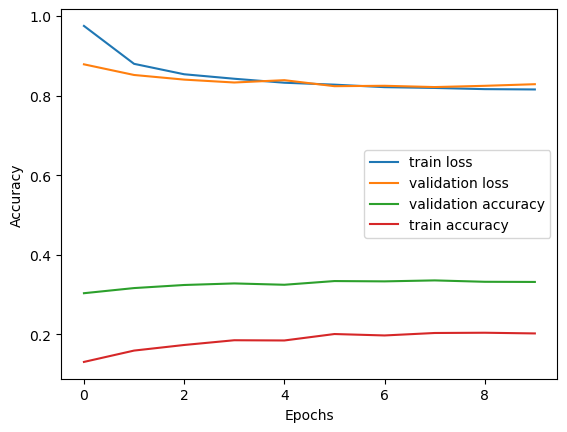

In [ ]:
Plot(train_losses,train_accuracies,val_losses,val_accuracies,path = BASE_DIR)

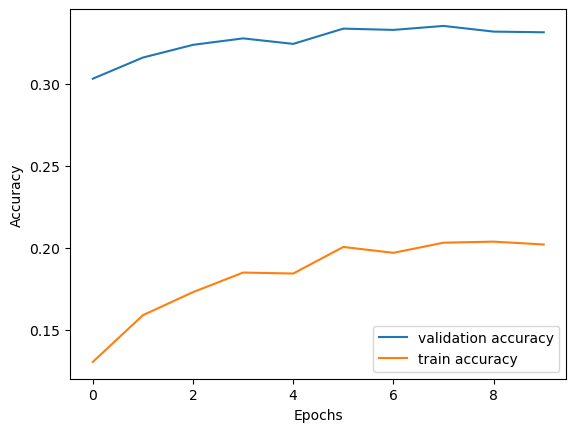

In [ ]:
plt.plot(val_accuracies,label = "validation accuracy")
plt.plot(train_accuracies,label = "train accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend() 